<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

<div align="left">
<a target="_blank" href="https://madewithml.com/"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# 🛠️ Setup

We'll be using [Ray](https://ray.io) to develop our application using distributed workloads.

In [1]:
import os
import ray
from dotenv import load_dotenv; load_dotenv()
import warnings; warnings.filterwarnings("ignore")

In [2]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-12-20 09:17:30,672	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'memory': 42381544653.0,
 'node:127.0.0.1': 1.0,
 'CPU': 10.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 2147483648.0}

These cluster resources only reflect our head node ([m5.2xlarge](https://instances.vantage.sh/aws/ec2/m5.2xlarge)). But recall in our [setup lesson](https://madewithml.com/courses/mlops/setup/) that our [compute configuration](https://madewithml.com/courses/mlops/setup/#compute) that we also added [g4dn.xlarge](https://instances.vantage.sh/aws/ec2/g4dn.xlarge) worker nodes (each has 1 GPU and 4 CPU) to our cluster. But because we set `min_workers=0`, our worker nodes will autoscale ( up to `max_workers`) as they're needed for specific workloads (ex. training). 

In [4]:
# # Workers (1 g4dn.xlarge)
# num_workers = 1
# resources_per_worker={"CPU": 3, "GPU": 1}

If you are running this on a local laptop (no GPU), use the CPU count from `ray.cluster_resources()` to set your resources. For example if your machine has 10 CPUs:

```python
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}
```

In [5]:
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}

In [6]:
# # Storage
# EFS_DIR = f"/efs/shared_storage/madewithml/{os.environ['GITHUB_USERNAME']}"
# print (EFS_DIR)

# Data

## 🔢 Data ingestion

In [7]:
import pandas as pd

In [8]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## ✂️ Data splitting

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [11]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [13]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [15]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

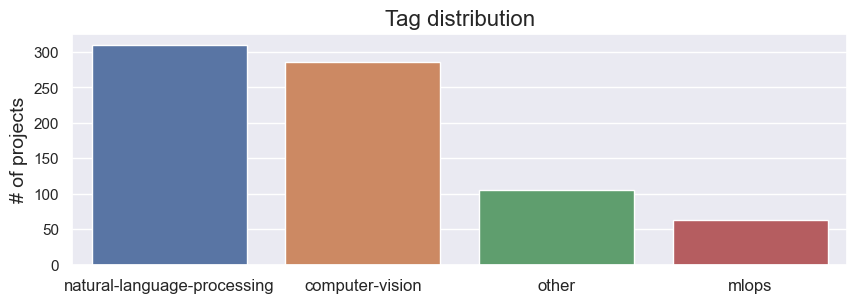

In [16]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

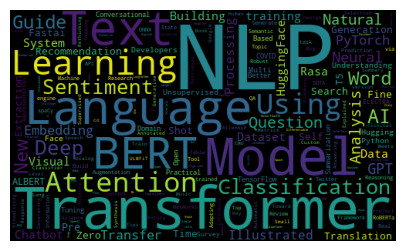

In [17]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [19]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [20]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sguys99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [22]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [23]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [24]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [25]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [26]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [27]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [28]:
import numpy as np
from transformers import BertTokenizer

In [29]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [30]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [31]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

<hr>

We'll combine all of our preprocessing steps into function:

In [32]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [33]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [34]:
import sys
sys.path.append("..")
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [35]:
from ray.data import Dataset
from typing import Dict, List, Tuple

def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [36]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-12-20 09:17:51,760	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2023-12-20 09:17:51,768	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-12-20 09:17:51,770	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-20 09:17:51,771	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:17:51,771	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 549,
  'created_on': datetime.datetime(2020, 4, 16, 3, 48, 35),
  'title': '15 Best Tools for Tracking Machine Learning Experiments',
  'description': 'A feature comparison of all the open-source and commercial options for experiment tracking.',
  'tag': 'mlops'}]

In [37]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-12-20 09:17:53,876	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-20 09:17:53,877	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:17:53,879	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-12-20 09:17:54,550	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-12-20 09:17:54,550	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:17:54,551	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-20 09:17:55,568	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-12-20 09:17:55,568	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:17:55,569	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-12-20 09:17:58,072	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-12-20 09:17:58,072	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:17:58,073	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': array([  102,  6121,  2216,  2074,  6410,  2117,   487,  3254,  1906,
        2749,  3073, 30108,   626,  3254,  1906,  8165, 30108, 14850,
        2743, 11571,  6410,  2216, 24348,  1738,  6984,   287,   489,
        3073,  4725,  1458,  1446,  3745,   545,  1884, 15308, 10288,
         103]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be: 

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our [other lessons](https://madewithml.com/#foundations) but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

In [40]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [41]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [42]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [43]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## 🤖 Model

In [44]:
import torch.nn as nn
from transformers import BertModel

In [45]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [47]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [48]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [49]:
from ray.train.torch import get_device

In [50]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [51]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [52]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2023-12-20 09:18:13,287	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-12-20 09:18:13,288	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:13,289	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2389, 29477,  ...,     0,     0,     0],
         [  102, 20439,  4681,  ...,     0,     0,     0],
         [  102,   864,   864,  ...,     0,     0,     0],
         ...,
         [  102,  9205,  4872,  ...,     0,     0,     0],
         [  102,   502,  1371,  ...,     0,     0,     0],
         [  102,   287,   489,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2,
         2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 2, 1, 1, 2, 3, 0, 0, 3,
         2, 2, 3, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0,
         0, 2, 2, 1, 2, 3, 0, 0, 3, 2, 2, 3, 0, 2, 3, 0, 0, 2, 3, 2, 2, 1, 2, 0,
         2, 2, 

## 🧮 Utilities

In [53]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [54]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [55]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [56]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as [over-sampling](https://imbalanced-learn.org/stable/over_sampling.html) less frequent classes and [under-sampling](https://imbalanced-learn.org/stable/under_sampling.html) popular classes.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## 🗂️ Configurations

In [57]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [58]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [59]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="~/ray/ray_results")

## 🚂 Training

In [60]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-12-20 09:18:26,850	INFO read_api.py:406 -- To satisfy the requested parallelism of 20, each read task output is split into 20 smaller blocks.
2023-12-20 09:18:26,853	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-12-20 09:18:26,854	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:26,854	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-12-20 09:18:28,105	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-12-20 09:18:28,105	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:28,105	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-20 09:18:28,652	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-12-20 09:18:28,653	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:28,654	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-20 09:18:29,329	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-12-20 09:18:29,330	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:29,330	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

2023-12-20 09:18:30,614	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(20)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-12-20 09:18:30,615	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-12-20 09:18:30,615	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/400 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/400 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/400 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/400 [00:00<?, ?it/s]

Running 0:   0%|          | 0/400 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/20 [00:00<?, ?it/s]

In [62]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [63]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [64]:
%%time
# Train
results = trainer.fit()

(TorchTrainer pid=41565) Starting distributed worker processes: ['41568 (127.0.0.1)', '41569 (127.0.0.1)', '41570 (127.0.0.1)', '41571 (127.0.0.1)', '41572 (127.0.0.1)', '41573 (127.0.0.1)']
(RayTrainWorker pid=41568) Setting up process group for: env:// [rank=0, world_size=6]
(RayTrainWorker pid=41573) [W ProcessGroupGloo.cpp:725] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())
(SplitCoordinator pid=41575) Auto configuring locality_with_output=['76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907']
(RayTrainWorker pid=41569) Some weights of the 

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41569) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000000)
(RayTrainWorker pid=41570) [W ProcessGroupGloo.cpp:725] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator()) [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=41570) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model). [repeated 5x across cluster]
(RayTrainWorker pid=41570) - This IS NOT expect

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41573) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000001) [repeated 6x across cluster]
2023-12-20 09:19:36,814	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41572) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000002) [repeated 6x across cluster]
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907', '76f70d4fd4d03bc0050e09553ebf2495e8a9bdeb097bfa1c8ab67907'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=41575) Tip: For detailed progress reportin

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41570) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000003) [repeated 6x across cluster]
2023-12-20 09:20:21,506	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41572) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000004) [repeated 6x across cluster]
2023-12-20 09:20:44,353	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41568) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000005) [repeated 6x across cluster]
2023-12-20 09:21:06,542	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41572) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000006) [repeated 6x across cluster]
2023-12-20 09:21:29,034	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41570) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000007) [repeated 6x across cluster]
2023-12-20 09:21:51,301	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41568) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000008) [repeated 6x across cluster]
2023-12-20 09:22:13,574	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=41575) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(6, equal=True)]
(SplitCoordinator pid=41575) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=Non

(pid=41575) Running 0:   0%|          | 0/20 [00:00<?, ?it/s]

(RayTrainWorker pid=41570) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000009) [repeated 6x across cluster]
2023-12-20 09:22:35,906	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2023-12-20 09:22:37,150	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more

CPU times: user 1.21 s, sys: 558 ms, total: 1.77 s
Wall time: 3min 58s


In [65]:
# Metrics per epoch
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.583856,0.492378,1703031553,True,False,1,52713_00000,2023-12-20_09-19-13,...,33.388903,1,checkpoint_000000,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.496678,0.459452,1703031576,True,False,2,52713_00000,2023-12-20_09-19-36,...,56.552291,2,checkpoint_000001,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.424180,0.351639,1703031598,True,False,3,52713_00000,2023-12-20_09-19-59,...,78.943179,3,checkpoint_000002,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.302633,0.292598,1703031621,True,False,4,52713_00000,2023-12-20_09-20-21,...,101.110946,4,checkpoint_000003,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.231597,0.214875,1703031643,True,False,5,52713_00000,2023-12-20_09-20-44,...,123.807984,5,checkpoint_000004,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.165674,0.216487,1703031665,True,False,6,52713_00000,2023-12-20_09-21-06,...,145.995455,6,checkpoint_000005,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.102957,0.160779,1703031687,True,False,7,52713_00000,2023-12-20_09-21-28,...,168.357719,7,checkpoint_000006,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.078738,0.150866,1703031710,True,False,8,52713_00000,2023-12-20_09-21-51,...,190.621183,8,checkpoint_000007,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.061140,0.142966,1703031732,True,False,9,52713_00000,2023-12-20_09-22-13,...,212.775328,9,checkpoint_000008,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.053165,0.138959,1703031755,True,False,10,52713_00000,2023-12-20_09-22-35,...,234.965286,10,checkpoint_000009,0.5,0.0001,0.8,3,10,256,4


In [66]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/Users/sguys99/ray/ray_results/llm/TorchTrainer_52713_00000_0_2023-12-20_09-18-38/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.05316528181234995,
   'val_loss': 0.1389585305005312,
   'timestamp': 1703031755,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 10,
   'trial_id': '52713_00000',
   'date': '2023-12-20_09-22-35',
   'time_this_iter_s': 22.18995714187622,
   'time_total_s': 234.96528553962708,
   'pid': 41565,
   'hostname': 'kmyu.local',
   'node_ip': '127.0.0.1',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 234.96528553962708,
   'iterations_since_restore': 10})]

### Evaluation

In [65]:
from sklearn.metrics import precision_recall_fscore_support

In [66]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [67]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [68]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2023-09-17 22:41:46,264	INFO read_api.py:406 -- To satisfy the requested parallelism of 64, each read task output is split into 64 smaller blocks.
2023-09-17 22:41:46,268	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-09-17 22:41:46,268	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:41:46,269	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
  'targets': 3}]

In [69]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2023-09-17 22:41:46,831	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-09-17 22:41:46,831	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:41:46,832	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [70]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

2023-09-17 22:41:47,783	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-09-17 22:41:47,785	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:41:47,786	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=348532, ip=10.0.34.101) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


In [71]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9138952286238713,
 'recall': 0.9109947643979057,
 'f1': 0.9114851103432928}

In [72]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [73]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-09-17 22:41:54,734	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-09-17 22:41:54,734	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:41:54,735	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

2023-09-17 22:41:55,455	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-09-17 22:41:55,456	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:41:55,456	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

{
  "precision": 0.9138952286238713,
  "recall": 0.9109947643979057,
  "f1": 0.9114851103432928
}


### Inference

In [74]:
import pandas as pd

In [75]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [76]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [77]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-09-17 22:42:00,133	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:42:00,134	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:00,134	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00035399722,
   'mlops': 0.00030543839,
   'natural-language-processing': 0.9990171,
   'other': 0.0003234732}}]

# 🧪 Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

There are many options for experiment tracking but we're going to use [MLflow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://docs.ray.io/en/latest/tune/examples/tune-mlflow.html)). There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

In [78]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

In [79]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///efs/shared_storage/madewithml/GokuMohandas/mlflow


In [80]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [81]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

In [82]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-09-17 22:42:01,332	INFO read_api.py:406 -- To satisfy the requested parallelism of 64, each read task output is split into 64 smaller blocks.
2023-09-17 22:42:01,337	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-09-17 22:42:01,337	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:01,338	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-09-17 22:42:01,795	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-09-17 22:42:01,795	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:01,796	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:42:03,339	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-09-17 22:42:03,340	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:03,340	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:42:05,078	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-17 22:42:05,079	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:05,079	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:42:07,292	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-17 22:42:07,293	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:42:07,293	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [84]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [85]:
%%time
# Train
results = trainer.fit()

(TorchTrainer pid=844750) Starting distributed worker processes: ['844833 (10.0.35.174)']
(RayTrainWorker pid=844833) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=844909) Auto configuring locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a']
(RayTrainWorker pid=844833) Moving model to device: cuda:0


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at

(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000001)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000002)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000003)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000004)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000005)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000006)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:43:01,995	WARNING worker.py:2012 -- [tqdm_ray] Failed to decode {"__magic_token__": "__ray_tqdm_magic_token__", "x": 47, "pos": 0, "desc": "Running: 0.0/32.0 CPU, 0.0/2.0 GPU, 0.28 MiB/8.95 GiB object_store_memory", "total": 64, "ip": "10.0.35.174", "pid": 844909, "uuid": "54df93474628434c, this may be due to logging too fast. This warning will not be printed again.


(SplitCoordinator pid=844909) 8d2fe8f67788261f", "closed": false}


(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000007)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000008)


(pid=844909) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=844909) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=844909) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=844909) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=844833) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-42-09/TorchTrainer_1bd07_00000_0_2023-09-17_22-42-09/checkpoint_000009)
2023-09-17 22:43:31,004	INFO tune.py:1143 -- Total run time: 81.76 seconds (81.66 seconds for the tuning loop).


CPU times: user 1.23 s, sys: 1.31 s, total: 2.53 s
Wall time: 1min 21s


In [86]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.577780,0.493102,1695015745,True,False,1,1bd07_00000,2023-09-17_22-42-25,...,11.882575,1,checkpoint_000000,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.489653,0.431958,1695015751,True,False,2,1bd07_00000,2023-09-17_22-42-31,...,17.654435,2,checkpoint_000001,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.398824,0.306201,1695015757,True,False,3,1bd07_00000,2023-09-17_22-42-37,...,23.353752,3,checkpoint_000002,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.300513,0.238803,1695015763,True,False,4,1bd07_00000,2023-09-17_22-42-43,...,29.118992,4,checkpoint_000003,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.220608,0.174411,1695015769,True,False,5,1bd07_00000,2023-09-17_22-42-49,...,34.897485,5,checkpoint_000004,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.151499,0.158648,1695015775,True,False,6,1bd07_00000,2023-09-17_22-42-55,...,40.645384,6,checkpoint_000005,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.105087,0.112829,1695015781,True,False,7,1bd07_00000,2023-09-17_22-43-01,...,46.387568,7,checkpoint_000006,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.077385,0.091922,1695015788,True,False,8,1bd07_00000,2023-09-17_22-43-08,...,52.153343,8,checkpoint_000007,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.053857,0.109810,1695015794,True,False,9,1bd07_00000,2023-09-17_22-43-14,...,57.901084,9,checkpoint_000008,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.042199,0.121122,1695015800,True,False,10,1bd07_00000,2023-09-17_22-43-20,...,63.699444,10,checkpoint_000009,0.5,0.0001,0.8,3,10,256,4


In [87]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.config/train_loop_config/lr_patience,metrics.time_total_s,metrics.time_since_restore,metrics.config/train_loop_config/num_epochs,...,metrics.epoch,params.train_loop_config/num_epochs,params.train_loop_config/lr_patience,params.train_loop_config/batch_size,params.train_loop_config/lr,params.train_loop_config/lr_factor,params.train_loop_config/num_classes,params.train_loop_config/dropout_p,tags.trial_name,tags.mlflow.runName
0,a67f6ec4e10b49a7845b91db61efc7e0,703905858072772764,FINISHED,file:///efs/shared_storage/madewithml/GokuMoha...,2023-09-18 05:42:12.863000+00:00,2023-09-18 05:43:30.925000+00:00,3.0,63.699444,63.699444,10.0,...,9.0,10,3,256,0.0001,0.8,4,0.5,TorchTrainer_1bd07_00000,TorchTrainer_1bd07_00000


In [88]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           a67f6ec4e10b49a7845b91db61efc7e0
experiment_id                                                                  703905858072772764
status                                                                                   FINISHED
artifact_uri                                    file:///efs/shared_storage/madewithml/GokuMoha...
start_time                                                       2023-09-18 05:42:12.863000+00:00
end_time                                                         2023-09-18 05:43:30.925000+00:00
metrics.config/train_loop_config/lr_patience                                                  3.0
metrics.time_total_s                                                                    63.699444
metrics.time_since_restore                                                              63.699444
metrics.config/train_loop_config/num_epochs                                                  10.0
metrics.iterations_s

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow
```

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/dashboard.png" width="1000" alt="mlflow runs">

And within each run, we can view metrics, parameters, artifacts, etc.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/params.png" width="1000" alt="mlflow params">

And we can even create custom plots to help us visualize our results.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/plots.png" width="1000" alt="mlflow plots">

### Loading

In [89]:
from ray.train import Result
from urllib.parse import urlparse

In [90]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [91]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [92]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-09-17 22:43:36,691	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-09-17 22:43:36,692	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:36,692	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

2023-09-17 22:43:37,551	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-09-17 22:43:37,552	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:37,553	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=845827) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{
  "precision": 0.9168092951711627,
  "recall": 0.9109947643979057,
  "f1": 0.9105512639658029
}


In [93]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-09-17 22:43:43,282	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:43:43,282	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:43,283	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00043165276,
   'mlops': 0.0008155016,
   'natural-language-processing': 0.9978746,
   'other': 0.0008782037}}]

# ⚙ Hyperparameter tuning

In [94]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [95]:
# Number of trials (small sample)
num_runs = 2

In [96]:
# Set up
set_seeds()

In [97]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-09-17 22:43:44,422	INFO read_api.py:406 -- To satisfy the requested parallelism of 64, each read task output is split into 64 smaller blocks.
2023-09-17 22:43:44,426	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-09-17 22:43:44,427	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:44,427	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [98]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-09-17 22:43:44,885	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-09-17 22:43:44,886	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:44,887	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:43:46,122	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-09-17 22:43:46,123	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:46,123	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:43:47,913	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-17 22:43:47,914	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:47,914	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-09-17 22:43:50,092	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-17 22:43:50,092	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:43:50,093	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4096 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4096 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4096 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4096 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [99]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [100]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [101]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

In [102]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [103]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [104]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [105]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [106]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [107]:
%%time
# Tune
results = tuner.fit()

(TorchTrainer pid=846705) Starting distributed worker processes: ['846788 (10.0.35.174)']
(RayTrainWorker pid=846788) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=846864) Auto configuring locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a']
(RayTrainWorker pid=846788) Moving model to device: cuda:0


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=846788) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at

(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000000)
(RayTrainWorker pid=349780, ip=10.0.34.101) Moving model to device: cuda:0
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorke

(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000001) [repeated 2x across cluster]
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:44:16,982	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 3.185 s, which may be a performance bottleneck.
2023-09-17 22:44:16,983	WARNING util.py:315 -- The `process_trial_result` operation took 3.187 s, which may be a performance bottleneck.
2023-09-17 22:44:16,984	WARNING util.py:315 -- Processing trial results took 3.188 s, which may be a performance bottleneck. Please consider reporting results 

(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000002) [repeated 2x across cluster]
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:44:25,141	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 3.025 s, which may be a performance bottleneck.
2023-09-17 22:44:25,143	WARNING util.py:315 -- The `process_trial_result` operation took 3.028 s, which may be a performance bottleneck.
2023-09-17 22:44:25,144	WARNING util.py:315 -- Processing trial results took 3.028 s, which may be a performance bottleneck. Please consider reporting results 

(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000003) [repeated 2x across cluster]
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:44:33,395	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 3.181 s, which may be a performance bottleneck.
2023-09-17 22:44:33,397	WARNING util.py:315 -- The `process_trial_result` operation took 3.183 s, which may be a performance bottleneck.
2023-09-17 22:44:33,398	WARNING util.py:315 -- Processing trial results took 3.184 s, which may be a performance bottleneck. Please consider reporting results 

(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000004) [repeated 2x across cluster]
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:44:41,574	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 3.101 s, which may be a performance bottleneck.
2023-09-17 22:44:41,576	WARNING util.py:315 -- The `process_trial_result` operation took 3.102 s, which may be a performance bottleneck.
2023-09-17 22:44:41,576	WARNING util.py:315 -- Processing trial results took 3.103 s, which may be a performance bottleneck. Please consider reporting results 

(pid=349841, ip=10.0.34.101) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000005) [repeated 2x across cluster]
(SplitCoordinator pid=349841, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=349841, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=349841, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:44:49,825	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 3.286 s, which may be a performance bottleneck.
2023-09-17 22:44:49,828	WARNING util.py:315 -- The `process_trial_result` operation took 3.289 s, which may be a performance bottleneck.
2023-09-17 22:44:49,828	WARNING util.py:315 -- Processing trial results took 3.289 s, which may be a performance bottleneck. Please consider reporting results 

(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000007)


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000008)


(pid=846864) Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(SplitCoordinator pid=846864) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=846864) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=846864) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=846788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/GokuMohandas/TorchTrainer_2023-09-17_22-43-52/TorchTrainer_639d7776_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-09-17_22-43-52/checkpoint_000009)
2023-09-17 22:45:41,369	INFO tune.py:1143 -- Total run time: 109.13 seconds (109.03 seconds for the tuning loop).


CPU times: user 1.67 s, sys: 1.85 s, total: 3.52 s
Wall time: 1min 49s


In [108]:
# All trials in experiment
results.get_dataframe()

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,logdir
0,9,0.000100,0.052036,0.096391,1695015936,True,True,10,639d7776,2023-09-17_22-45-36,...,ip-10-0-35-174,10.0.35.174,68.388524,10,checkpoint_000009,0.500000,0.000100,0.800000,3.000000,639d7776
1,4,0.000052,0.392521,0.326320,1695015885,True,True,5,145c1bc2,2023-09-17_22-44-46,...,ip-10-0-34-101,10.0.34.101,30.729746,5,checkpoint_000004,0.841192,0.000052,0.758627,2.253736,145c1bc2


In [109]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience
0,0,0.0001,0.577860,0.492227,1695015848,True,False,1,639d7776,2023-09-17_22-44-08,...,846705,ip-10-0-35-174,10.0.35.174,12.828465,1,checkpoint_000000,0.5,0.0001,0.8,3.0
1,1,0.0001,0.475743,0.387187,1695015856,True,False,2,639d7776,2023-09-17_22-44-16,...,846705,ip-10-0-35-174,10.0.35.174,20.651286,2,checkpoint_000001,0.5,0.0001,0.8,3.0
2,2,0.0001,0.402374,0.372390,1695015864,True,False,3,639d7776,2023-09-17_22-44-24,...,846705,ip-10-0-35-174,10.0.35.174,28.235628,3,checkpoint_000002,0.5,0.0001,0.8,3.0
3,3,0.0001,0.349068,0.297704,1695015873,True,False,4,639d7776,2023-09-17_22-44-33,...,846705,ip-10-0-35-174,10.0.35.174,35.873792,4,checkpoint_000003,0.5,0.0001,0.8,3.0
4,4,0.0001,0.256888,0.207574,1695015881,True,False,5,639d7776,2023-09-17_22-44-41,...,846705,ip-10-0-35-174,10.0.35.174,43.487612,5,checkpoint_000004,0.5,0.0001,0.8,3.0
5,5,0.0001,0.204279,0.161283,1695015889,True,False,6,639d7776,2023-09-17_22-44-49,...,846705,ip-10-0-35-174,10.0.35.174,51.113538,6,checkpoint_000005,0.5,0.0001,0.8,3.0
6,6,0.0001,0.142716,0.138546,1695015897,True,False,7,639d7776,2023-09-17_22-45-18,...,846705,ip-10-0-35-174,10.0.35.174,51.115670,7,checkpoint_000006,0.5,0.0001,0.8,3.0
7,7,0.0001,0.097615,0.108034,1695015924,True,False,8,639d7776,2023-09-17_22-45-24,...,846705,ip-10-0-35-174,10.0.35.174,56.781526,8,checkpoint_000007,0.5,0.0001,0.8,3.0
8,8,0.0001,0.070097,0.102292,1695015930,True,False,9,639d7776,2023-09-17_22-45-30,...,846705,ip-10-0-35-174,10.0.35.174,62.607184,9,checkpoint_000008,0.5,0.0001,0.8,3.0
9,9,0.0001,0.052036,0.096391,1695015936,True,True,10,639d7776,2023-09-17_22-45-36,...,846705,ip-10-0-35-174,10.0.35.174,68.388524,10,checkpoint_000009,0.5,0.0001,0.8,3.0


In [110]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

In [111]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.time_total_s,metrics.config/train_loop_config/lr_patience,metrics.time_since_restore,metrics.iterations_since_restore,...,metrics.config/train_loop_config/num_epochs,params.train_loop_config/lr,params.train_loop_config/lr_patience,params.train_loop_config/dropout_p,params.train_loop_config/lr_factor,params.train_loop_config/num_classes,params.train_loop_config/num_epochs,params.train_loop_config/batch_size,tags.trial_name,tags.mlflow.runName
0,ebc5576cd02e4430bbe949612a25bd45,703905858072772764,FINISHED,file:///efs/shared_storage/madewithml/GokuMoha...,2023-09-18 05:43:55.499000+00:00,2023-09-18 05:45:41.257000+00:00,68.388524,3.000000,68.388524,10.0,...,NaN,0.0001,3.0,0.5,0.8,None,None,None,TorchTrainer_639d7776,TorchTrainer_639d7776
1,a67f6ec4e10b49a7845b91db61efc7e0,703905858072772764,FINISHED,file:///efs/shared_storage/madewithml/GokuMoha...,2023-09-18 05:42:12.863000+00:00,2023-09-18 05:43:30.925000+00:00,63.699444,3.000000,63.699444,10.0,...,10.0,0.0001,3,0.5,0.8,4,10,256,TorchTrainer_1bd07_00000,TorchTrainer_1bd07_00000
2,0d8a50554ecf498cb6f1471b58aedb9d,703905858072772764,FINISHED,file:///efs/shared_storage/madewithml/GokuMoha...,2023-09-18 05:43:59.010000+00:00,2023-09-18 05:45:17.549000+00:00,30.729746,2.253736,30.729746,5.0,...,NaN,5.1804178109970566e-05,2.253735644669187,0.8411920116073033,0.7586266131367906,None,None,None,TorchTrainer_145c1bc2,TorchTrainer_145c1bc2


In [112]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [113]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-09-17 22:45:42,824	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-09-17 22:45:42,824	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:42,825	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

2023-09-17 22:45:43,740	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-09-17 22:45:43,741	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:43,742	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=350325, ip=10.0.34.101) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{
  "precision": 0.9168092951711627,
  "recall": 0.9109947643979057,
  "f1": 0.9105512639658029
}


In [114]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-09-17 22:45:49,875	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:45:49,875	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:49,876	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00043165276,
   'mlops': 0.0008155016,
   'natural-language-processing': 0.9978746,
   'other': 0.0008782037}}]

# ⚖️ Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [115]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [116]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [117]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2023-09-17 22:45:52,090	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-09-17 22:45:52,091	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:52,091	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

In [118]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

2023-09-17 22:45:52,987	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:45:52,988	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:52,988	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

In [119]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

(191,)
(191, 4)


In [120]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

,id,created_on,title,description,tag,text,prediction
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...,computer-vision
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other,Graph Wavelet Neural Network A PyTorch impleme...,other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other,Capsule Graph Neural Network A PyTorch impleme...,other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision,NeRF: Neural Radiance Fields Representing scen...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing,Mention Classifier Category prediction model\n...,natural-language-processing


### Coarse-grained metrics

In [121]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9138952286238713,
    "recall": 0.9109947643979057,
    "f1": 0.9114851103432928,
    "num_samples": 191.0
}


### Fine-grained metrics

In [122]:
from collections import OrderedDict

In [123]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [124]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.9146341463414634,
  "recall": 0.9615384615384616,
  "f1": 0.9375000000000001,
  "num_samples": 78.0
}


In [125]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "other",
  {
    "precision": 0.96,
    "recall": 0.9230769230769231,
    "f1": 0.9411764705882353,
    "num_samples": 26.0
  }
]
[
  "natural-language-processing",
  {
    "precision": 0.9146341463414634,
    "recall": 0.9615384615384616,
    "f1": 0.9375000000000001,
    "num_samples": 78.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9393939393939394,
    "recall": 0.8732394366197183,
    "f1": 0.9051094890510948,
    "num_samples": 71.0
  }
]
[
  "mlops",
  {
    "precision": 0.7222222222222222,
    "recall": 0.8125,
    "f1": 0.7647058823529411,
    "num_samples": 16.0
  }
]


### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [126]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [127]:
print (tp)
print (fp)
print (fn)

[4, 9, 12, 17, 19, 23, 25, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 68, 71, 75, 77, 78, 79, 82, 92, 94, 95, 97, 99, 101, 109, 113, 114, 115, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[41, 61, 102, 104, 154, 165, 188]
[16, 76, 112]


In [128]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
How Docker Can Help You Become A More Effective Data Scientist A look at Docker from the perspective of a data scientist.
    true: mlops
    pred: natural-language-processing

Differential Subspace Search in High-Dimensional Lat

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [129]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [130]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i], 
            "pred": test_df.prediction[i], 
            "prob": prob})

In [131]:
low_confidence[0:3]

[{'text': 'The Unreasonable Effectiveness of Recurrent Neural Networks A close look at how RNNs are able to perform so well.',
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.008757317},
 {'text': 'Machine Learning Projects  This Repo contains projects done by me while learning the basics. All the familiar types of regression, classification, and clustering methods have been used.',
  'true': 'natural-language-processing',
  'pred': 'mlops',
  'prob': 0.020190474}]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them. 

<div class="ai-center-all">
    <img src="https://madewithml.com/static/images/mlops/evaluation/calibration.png" width="300" alt="accuracy vs. confidence">
</div>
<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [132]:
import cleanlab
from cleanlab.filter import find_label_issues

In [133]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

*** SIGTERM received at time=1695015958 on cpu 1 ***
PC: @           0x4edd8a  (unknown)  _PyEval_MakeFrameVector
    @     0x7fe3ff0e9420  514711536  (unknown)
    @           0x72c720  (unknown)  (unknown)
[2023-09-17 22:45:58,798 E 848689 841208] logging.cc:361: *** SIGTERM received at time=1695015958 on cpu 1 ***
[2023-09-17 22:45:58,799 E 848689 841208] logging.cc:361: PC: @           0x4edd8a  (unknown)  _PyEval_MakeFrameVector
[2023-09-17 22:45:58,803 E 848689 841208] logging.cc:361:     @     0x7fe3ff0e9420  514711536  (unknown)
[2023-09-17 22:45:58,808 E 848689 841208] logging.cc:361:     @           0x72c720  (unknown)  (unknown)


,id,created_on,title,description,tag,prediction
103,1459,2020-06-16 03:06:10,SuperGlue: Learning Feature Matching with Grap...,"SuperGlue, a neural network that matches two s...",other,computer-vision
102,1451,2020-06-16 01:21:09,EfficientDet (PyTorch),A PyTorch implementation of EfficientDet faith...,computer-vision,natural-language-processing
165,2137,2020-08-13 02:10:03,Unpopular Opinion - Data Scientists Should Be ...,I believe data scientists can be more effectiv...,mlops,natural-language-processing
61,710,2020-05-05 04:01:24,Differential Subspace Search in High-Dimension...,Differential subspace search to allow efficien...,computer-vision,natural-language-processing
16,264,2020-04-06 21:33:32,The Unreasonable Effectiveness of Recurrent Ne...,A close look at how RNNs are able to perform s...,natural-language-processing,computer-vision


Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead (it does but we simplified it for this course).

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [134]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [135]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [136]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [137]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 32805.57it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [138]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 64413.61it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [139]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 27137.02it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [140]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [141]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 28
  },
  "short_text": {
    "precision": 0.8571428571428571,
    "recall": 0.8571428571428571,
    "f1": 0.8571428571428571,
    "num_samples": 7
  }
}


Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [142]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [143]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [144]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

2023-09-17 22:45:59,447	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:45:59,447	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:45:59,448	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

### Behavioral testing

In [145]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:15,716	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:15,717	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:15,718	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

In [146]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:16,783	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:16,784	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:16,784	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

In [147]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-09-17 22:46:17,810	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-09-17 22:46:17,811	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:17,811	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'mlops']

We'll learn how to systematically create tests in our [testing lesson](https://madewithml.com/courses/mlops/testing#behavioral-testing). Be sure to also checkout the [evaluation lesson](https://madewithml.com/courses/mlops/evaluation) where we cover more ways to evaluate our model, including generating slices, counterfactuals and more.

# 🚀 Serving 

### Batch inference (offline)

In [148]:
import ray.data
from ray.data import ActorPoolStrategy

In [149]:
# Artifacts
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [150]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

2023-09-17 22:46:24,211	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(64)] -> ActorPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-09-17 22:46:24,213	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-17 22:46:24,214	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-17 22:46:24,951	INFO actor_pool_map_operator.py:106 -- MapBatches(preprocess)->MapBatches(TorchPredictor): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/4096 [00:00<?, ?it/s]

(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=848995) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


array([0, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 2, 3, 2, 3, 0,
       3, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0,
       0, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 1, 2, 3, 3, 3, 3, 2, 0, 0, 0, 2,
       2, 3, 2, 1, 0, 2, 3, 1, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 2, 3, 0, 2, 0, 2, 3, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 1, 1, 2, 0,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 1, 3, 0, 2, 2, 0, 1, 2, 1, 2, 2])

### Online inference (real-time)

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [151]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [152]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.", 
    version="0.1")

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

In [153]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

> `async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

In [154]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

Connecting to existing Serve app in namespace "serve". New http options will not be applied.


(ServeController pid=840558) INFO 2023-09-17 22:46:46,923 controller 840558 deployment_state.py:1390 - Deploying new version of deployment ModelDeployment in application 'default'.
(ServeController pid=840558) INFO 2023-09-17 22:46:47,027 controller 840558 deployment_state.py:1560 - Stopping 1 replicas of deployment 'ModelDeployment' in application 'default' with outdated versions.
(ServeController pid=840558) INFO 2023-09-17 22:46:47,027 controller 840558 http_state.py:265 - Start to drain the proxy actor on node 860a06117a62bfc12416a8163d19974a865e594674344a920da1e53b
(ServeController pid=840558) INFO 2023-09-17 22:46:49,260 controller 840558 deployment_state.py:2027 - Replica default#ModelDeployment#qtfPwF is stopped.
(ServeController pid=840558) INFO 2023-09-17 22:46:49,261 controller 840558 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeployment in application 'default'.
(ServeController pid=840558) INFO 2023-09-17 22:46:52,625 controller 840558 http_state.py:276

Deployment 'ModelDeployment:fHCaeN' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeployment


2023-09-17 22:46:58,941	INFO router.py:1226 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2023-09-17 22:46:58,947	INFO router.py:537 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': {'default#ModelDeployment#aAAvxd'}.


RayServeSyncHandle(deployment='ModelDeployment')

In [155]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=350914, ip=10.0.34.101) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=351034, ip=10.0.34.101) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.0006470938096754253,
    'mlops': 0.0003823915321845561,
    'natural-language-processing': 0.9983959794044495,
    'other': 0.0005744708469137549}}]}

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [156]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) INFO 2023-09-17 22:47:02,865 ModelDeployment default#ModelDeployment#aAAvxd 7abfafdb-67ae-4204-a021-9f7507e22f78 /predict/ default replica.py:749 - __CALL__ OK 3898.9ms
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=350914, ip=10.0.34.101) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=849454) /tmp/ipykernel_841208/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.010165845975279808,
    'mlops': 0.2043360322713852,
    'natural-language-processing': 0.05693763121962547,
    'other': 0.7285605072975159}}]}

In [157]:
# Shutdown
serve.shutdown()

2023-09-17 22:47:06,943	INFO router.py:537 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': set().
(ServeReplica:default:ModelDeployment pid=350914, ip=10.0.34.101) INFO 2023-09-17 22:47:06,917 ModelDeployment default#ModelDeployment#aAAvxd 3c3a4798-af4d-45f3-a2b1-c73d15e1ce83 /predict/ default replica.py:749 - __CALL__ OK 4037.2ms
(ServeController pid=840558) INFO 2023-09-17 22:47:06,939 controller 840558 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeployment' in application 'default'.
(ServeController pid=840558) INFO 2023-09-17 22:47:09,134 controller 840558 deployment_state.py:2027 - Replica default#ModelDeployment#aAAvxd is stopped.


### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the `other` class if the probability of the predicted class is below a certain `threshold` probability.

In [162]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 8, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        
        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [163]:
# Run service
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

(ServeController pid=850735) INFO 2023-09-17 22:48:54,599 controller 850735 application_state.py:183 - Recovering target state for application 'default' from checkpoint.


Started detached Serve instance in namespace "serve".


(HTTPProxyActor pid=850784) INFO 2023-09-17 22:48:55,884 http_proxy 10.0.35.174 http_proxy.py:1441 - Proxy actor 8bf33b9832cc186ec5c3be470b000000 starting on node c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a.
(HTTPProxyActor pid=850784) INFO 2023-09-17 22:48:55,890 http_proxy 10.0.35.174 http_proxy.py:1626 - Starting HTTP server on node: c268d87a05f14889a7bdc3c259e78ced37c574c65ab440657e85be5a listening on port 8000
(HTTPProxyActor pid=850784) INFO:     Started server process [850784]
(ServeController pid=850735) INFO 2023-09-17 22:48:56,036 controller 850735 deployment_state.py:1390 - Deploying new version of deployment ModelDeploymentRobust in application 'default'.
(ServeController pid=850735) INFO 2023-09-17 22:48:56,138 controller 850735 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeploymentRobust in application 'default'.


Deployment 'ModelDeploymentRobust:tMjDvR' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeploymentRobust


2023-09-17 22:49:02,011	INFO router.py:1226 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2023-09-17 22:49:02,015	INFO router.py:537 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': {'default#ModelDeploymentRobust#YziEno'}.


RayServeSyncHandle(deployment='ModelDeploymentRobust')

In [167]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeploymentRobust pid=850829) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeploymentRobust pid=850829) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeploymentRobust pid=850829) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=850829) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.010165845975279808,
    'mlops': 0.2043360322713852,
    'natural-language-processing': 0.05693763121962547,
    'other': 0.7285605072975159}}]}

(ServeReplica:default:ModelDeploymentRobust pid=850829) INFO 2023-09-17 22:49:40,637 ModelDeploymentRobust default#ModelDeploymentRobust#YziEno 333d113e-1023-404d-b299-f40a53693dca /predict/ default replica.py:749 - __CALL__ OK 840.9ms


In [161]:
# Shutdown
serve.shutdown()

2023-09-17 22:47:23,037	INFO router.py:537 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': set().
(ServeController pid=849560) INFO 2023-09-17 22:47:23,033 controller 849560 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeploymentRobust' in application 'default'.
(ServeReplica:default:ModelDeploymentRobust pid=849661) INFO 2023-09-17 22:47:22,994 ModelDeploymentRobust default#ModelDeploymentRobust#MzdUXm 0b2038b6-fe98-4a0d-a31b-a1034a075ebf /predict/ default replica.py:749 - __CALL__ OK 3964.4ms
(ServeController pid=849560) INFO 2023-09-17 22:47:25,326 controller 849560 deployment_state.py:2027 - Replica default#ModelDeploymentRobust#MzdUXm is stopped.


---